In [2]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install gensim==3.8.3 --quiet
!pip install -U tensorflow_text==2.8.2 --quiet
!pip install tensorflow-datasets --quiet
!pip install pydot --quiet
!pip install tensorflow==2.8.2 --quiet

     |████████████████████████████████| 451 kB 5.4 MB/s 
     |████████████████████████████████| 115 kB 14.4 MB/s 
     |████████████████████████████████| 182 kB 19.6 MB/s 
     |████████████████████████████████| 212 kB 17.3 MB/s 
     |████████████████████████████████| 127 kB 6.1 MB/s 
     |████████████████████████████████| 5.5 MB 20.2 MB/s 
     |████████████████████████████████| 7.6 MB 54.7 MB/s 
     |████████████████████████████████| 24.2 MB 1.5 MB/s 
     |████████████████████████████████| 4.9 MB 24.0 MB/s 
     |████████████████████████████████| 497.9 MB 4.8 kB/s 
     |████████████████████████████████| 5.8 MB 66.3 MB/s 
     |████████████████████████████████| 462 kB 54.1 MB/s 
     |████████████████████████████████| 1.4 MB 52.8 MB/s 
     |████████████████████████████████| 437.8 MB 39 kB/s 


In [3]:
import os
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import pandas as pd
import transformers
import gensim
from datasets import load_dataset

from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from pprint import pprint 
from datasets import load_dataset
from nltk.corpus import reuters
from nltk.data import find
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from transformers import BertTokenizer, TFBertModel

In [4]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
df = pd.read_csv(url, index_col=0)
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Field Description from  Davidson et.al github

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [5]:
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


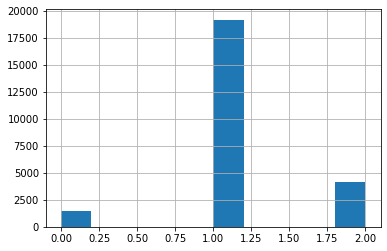

In [6]:
df['class'].hist()

In [7]:
df['tweet'].head()

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object

Light Data Cleaning

In [8]:
df['tweet'][0].split(": ")[1:]

["As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."]

In [9]:
# Remove the initial exclamation points and the RT twitter handles
df['tweet'] = df['tweet'].apply(lambda x: ": ".join(x.split(": ")[1:]) if len(x.split(": ")) > 1 else x)
df['tweet']

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2        You ever fuck a bitch and she start to cry? Yo...
3                       @viva_based she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    @20_Pearls @corey_emanuel right! His TL is tra...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat!!.. dat nigguh like I ain...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [10]:
# remove the unicode symbols 
import re
df['tweet'] = df['tweet'].apply(lambda x: re.sub("&#\d+","",x))

# remove other @handles 
df['tweet'] = df['tweet'].apply(lambda x: re.sub("@[^ ]+ ","",x))
df['tweet']

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2        You ever fuck a bitch and she start to cry? Yo...
3                                   she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    right! His TL is trash ;. Now, mine? Bible scr...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat!!.. dat nigguh like I ain...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [11]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about cleani...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,3,0,3,0,1,You ever fuck a bitch and she start to cry? Yo...
3,3,0,2,1,1,she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or it...
...,...,...,...,...,...,...
25291,3,0,2,1,1,"right! His TL is trash ;. Now, mine? Bible scr..."
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


Very large skew towards offensive langauge in the dataset

In [12]:
training_tweets, testing_tweets = train_test_split(df, test_size=0.2, random_state=25, stratify = df['class'])
valid_tweets, testing_tweets = train_test_split(testing_tweets, test_size = 0.5, random_state=25, stratify = testing_tweets['class'])

In [13]:
print(f"No. of training examples: {training_tweets.shape[0]}")
print(f"No. of validation examples: {valid_tweets.shape[0]}")
print(f"No. of testing examples: {testing_tweets.shape[0]}")

No. of training examples: 19826
No. of validation examples: 2478
No. of testing examples: 2479


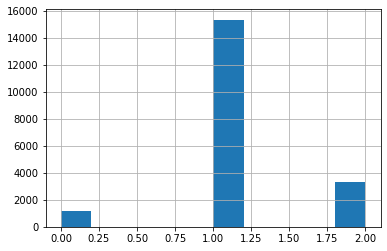

In [14]:
training_tweets['class'].hist()

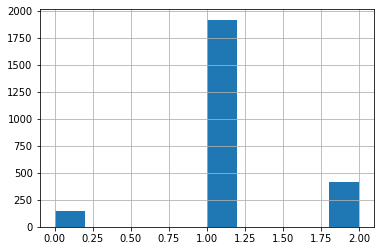

In [15]:
valid_tweets['class'].hist()

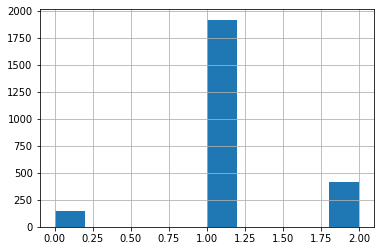

In [16]:
testing_tweets['class'].hist()

In [17]:
# get average length of tweets in the various sets
print("Average word length")
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print(valid_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print(testing_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print("Min max word length")
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).min())
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).max())

print("Average character length")
print(training_tweets['tweet'].apply(lambda x: len(x)).mean())
print(valid_tweets['tweet'].apply(lambda x: len(x)).mean())
print(testing_tweets['tweet'].apply(lambda x: len(x)).mean())

print("Min max character length")
print(training_tweets['tweet'].apply(lambda x: len(x)).min())
print(training_tweets['tweet'].apply(lambda x: len(x)).max())

Average word length
12.859427015030768
12.792171105730429
12.939491730536506
Min max word length
1
36
Average character length
68.69106224150106
68.10290556900726
68.71803146430013
Min max character length
1
148


In [18]:
#class_weight = n_samples / (n_classes * np.bincount(y))
print('training dataset class weights = ', training_tweets.shape[0] / (3 * np.bincount(training_tweets['class'])))
print('valid dataset class weights = ', valid_tweets.shape[0] / (3 * np.bincount(valid_tweets['class'])))
print('test dataset class weights = ', testing_tweets.shape[0] / (3 * np.bincount(testing_tweets['class'])))
class_weight = dict(enumerate(testing_tweets.shape[0] / (3 * np.bincount(testing_tweets['class']))))

training dataset class weights =  [5.77680653 0.43047594 1.98458458]
valid dataset class weights =  [5.77622378 0.43043252 1.98557692]
test dataset class weights =  [5.77855478 0.43060622 1.98161471]


In [19]:
max_length = 65

In [20]:
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [21]:
EMBEDDING_DIM = len(model['university']) 

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

vocab_dict['[UNK]'] = len(vocab_dict)

In [22]:
embedding_matrix.shape

(43982, 300)

In [23]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(training_tweets['tweet'])
valid_tokens = tokenizer.tokenize(valid_tweets['tweet'])
test_tokens = tokenizer.tokenize(testing_tweets['tweet'])

In [24]:
train_tokens[0]

<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'lol', b'tell', b'dat', b'white', b'bitch', b'I', b'said', b'hey'],
      dtype=object)>

In [25]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:max_length]
        n_padding = (max_length - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)

    return np.array(texts_vocab_ids)

In [26]:
train_input = docs_to_vocab_ids(train_tokens)
valid_input = docs_to_vocab_ids(valid_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(training_tweets['class'])
valid_labels = np.array(valid_tweets['class'])
test_labels = np.array(testing_tweets['class'])

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  0
Examples processed:  0


In [27]:
train_labels[1]

1

In [28]:
train_input[1]

array([ 6891, 30665, 25814,  3830, 43981, 43981, 43981, 43981, 43981,
       43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
       43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
       43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
       43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
       43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
       43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
       43981, 43981])

In [29]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(max_length,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=max_length,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(3, activation='softmax')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                      metrics=['accuracy'])
    return cnn_model

In [30]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100]
kernel_sizes = [ 10]
dense_layer_dims = [50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [31]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65)]              0         
                                                                 
 embedding (Embedding)       (None, 65, 300)           13194600  
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           300100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 concatenate (Concatenate)   (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                             

In [32]:
# unbalanced class weights
# cnn_history = cnn_model.fit(train_input,
#                             train_labels,
#                             validation_data=(valid_input, valid_labels),
#                             batch_size=32,
#                             epochs=5,
#                             )

In [33]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(valid_input, valid_labels),
                            batch_size=32,
                            epochs=5,
                            class_weight=class_weight
                            )

Epoch 1/5
620/620 [==============================] - 13s 5ms/step - loss: 0.9065 - accuracy: 0.5795 - val_loss: 0.7123 - val_accuracy: 0.6885
Epoch 2/5
620/620 [==============================] - 2s 4ms/step - loss: 0.7547 - accuracy: 0.6402 - val_loss: 0.7809 - val_accuracy: 0.6376
Epoch 3/5
620/620 [==============================] - 3s 4ms/step - loss: 0.6592 - accuracy: 0.6717 - val_loss: 0.7285 - val_accuracy: 0.6642
Epoch 4/5
620/620 [==============================] - 3s 5ms/step - loss: 0.5766 - accuracy: 0.7085 - val_loss: 0.6313 - val_accuracy: 0.7272
Epoch 5/5
620/620 [==============================] - 3s 5ms/step - loss: 0.4963 - accuracy: 0.7451 - val_loss: 0.6836 - val_accuracy: 0.6957


In [34]:
score = cnn_model.evaluate(test_input, test_labels)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

78/78 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.7285
Test loss: 0.6451106071472168
Test accuracy: 0.7285195589065552


In [35]:
predictions = cnn_model.predict(test_input)
predictions_classes = predictions.argmax(axis=-1)
predictions_classes

array([1, 2, 2, ..., 2, 1, 1])

In [36]:
pred_dict = {'test_predictions': predictions_classes, 'test_labels': test_labels}  
       
df = pd.DataFrame(pred_dict)

In [37]:
test_labels

array([1, 2, 2, ..., 2, 1, 2])

In [38]:
test_input

array([[43981,  8310, 37008, ..., 43981, 43981, 43981],
       [43981, 26318,  3617, ..., 43981, 43981, 43981],
       [43981, 42543, 43981, ..., 43981, 43981, 43981],
       ...,
       [40270, 37008, 33946, ..., 43981, 43981, 43981],
       [43981, 12917,  8092, ..., 43981, 43981, 43981],
       [43981,  3617, 16809, ..., 43981, 43981, 43981]])

In [39]:
# Save Result to a CSV file
# org_class, org_input, pred_class, output, output_class
save_csv_dict = {'org_class': test_labels, 'org_input': testing_tweets['tweet'], 'pred_class': predictions_classes}  
df_pred = pd.DataFrame(save_csv_dict) 
output_file_name = 'davidson_cnn_baseline.csv'
csv_path = 'drive/MyDrive/Colab Notebooks/w266_project_predictions/'
df_pred.to_csv(output_file_name, index = False) 

In [40]:
zero_labels = df[df['test_labels']==0]
one_labels = df[df['test_labels']==1]
two_labels = df[df['test_labels']==2]
print(len(zero_labels))
print(len(one_labels))
print(len(two_labels))

143
1919
417


In [41]:
incorrect_zero_labels = zero_labels[zero_labels['test_labels'] != zero_labels['test_predictions']]
incorrect_one_labels = one_labels[one_labels['test_labels'] != one_labels['test_predictions']]
incorrect_two_labels = two_labels[two_labels['test_labels'] != two_labels['test_predictions']]
print(len(incorrect_zero_labels))
print(len(incorrect_one_labels))
print(len(incorrect_two_labels))

81
504
88


In [42]:
correct_zero_labels = zero_labels[zero_labels['test_labels'] == zero_labels['test_predictions']]
correct_one_labels = one_labels[one_labels['test_labels'] == one_labels['test_predictions']]
correct_two_labels = two_labels[two_labels['test_labels'] == two_labels['test_predictions']]
print(len(correct_zero_labels))
print(len(correct_one_labels))
print(len(correct_two_labels))

62
1415
329


In [43]:
print("Accuracy for hate speech class (0): ", len(correct_zero_labels)/len(zero_labels))
print("Accuracy for offensive language class (1): ", len(correct_one_labels)/len(one_labels))
print("Accuracy for neither class (2): ", len(correct_two_labels)/len(two_labels))

Accuracy for hate speech class (0):  0.43356643356643354
Accuracy for offensive language class (1):  0.7373632100052111
Accuracy for neither class (2):  0.7889688249400479


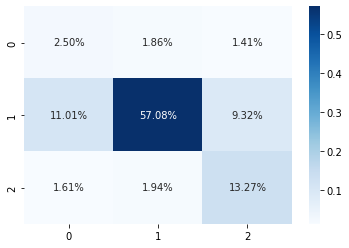

In [44]:
cnn_cf = confusion_matrix(testing_tweets['class'],predictions_classes)
sns.heatmap(cnn_cf/np.sum(cnn_cf), annot=True, fmt='.2%', cmap='Blues')

In [47]:
print(classification_report(testing_tweets['class'], predictions_classes, target_names=['0','1','2']))

              precision    recall  f1-score   support

           0       0.17      0.43      0.24       143
           1       0.94      0.74      0.83      1919
           2       0.55      0.79      0.65       417

    accuracy                           0.73      2479
   macro avg       0.55      0.65      0.57      2479
weighted avg       0.83      0.73      0.76      2479

